In [2]:
path = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'

# Libraries

In [4]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import cv2
import timeit
import numpy as np 
import pandas as pd
from PIL import Image
from tensorflow import keras
import tensorflow as tf
from keras import Model
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Conv2D,Dense,Activation,Conv2DTranspose,Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D,AveragePooling2D,GlobalAveragePooling2D,Concatenate

In [5]:
def num (image) :
    val = 0
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    return val

In [6]:
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m= np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [7]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
        
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                           # to X as benign , normal
                X_n[num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[num(image)-1]+= img_to_array(pil_img)
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                           # mask to y.
                y_n[num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                y_m[num(image)-1]+= img_to_array(pil_img)

In [8]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [9]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [10]:
def convertToOneChannel(img):
    im=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    i=cv2.resize(im, (128, 128))
    return i

In [11]:
def convertToThreeChannel(img):
    b_np= np.array(img)
    g_np= np.array(img)
    r_np= np.array(img)
    final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
    return np.array(final_img)

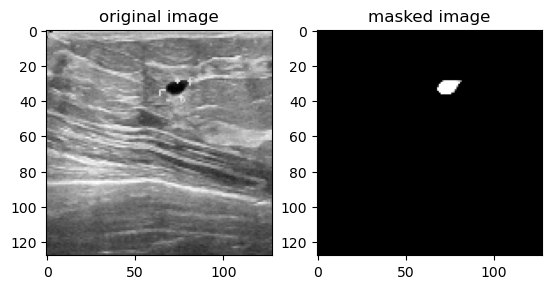

In [12]:
img=convertToThreeChannel(X[10])
mask=convertToThreeChannel(y[10])
plt.figure
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("masked image")
plt.show()

In [13]:
actual=[]
mask=[]
for i in X:
    horizontal_flip = cv2.flip(i, 1)
    vertical_horizontal_flip = cv2.flip(i, -1)
    imagerotate = cv2.rotate(i, cv2.ROTATE_180) 
    imagerotate1 = cv2.rotate(i, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate2 = cv2.rotate(i, cv2.ROTATE_90_CLOCKWISE)
    actual.append(horizontal_flip)
    actual.append(vertical_horizontal_flip)
    actual.append(imagerotate)
    actual.append(imagerotate1)
    actual.append(imagerotate2)

for j in y:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)    

In [14]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [15]:
actual=actual/255
mask=mask/255
print(mask.max())
print(mask.min())

2.0
0.0


In [16]:
mask[mask > 1.0] = 1.0

In [17]:
print(mask.max())
print(mask.min())

1.0
0.0


In [18]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [19]:
t1=np.full(2185,1) 
t2=np.full(665,0)
t3=np.full(1050,2)  
T=np.concatenate((t1, t2, t3), axis = 0)
T=np.array(T)

In [20]:
print(T.shape)

(3900,)


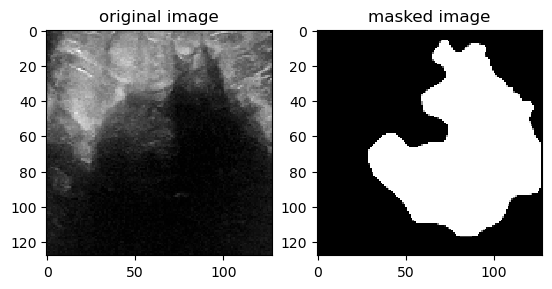

In [21]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title("masked image")
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(actual, mask, test_size = 0.15, random_state = 1)

In [23]:
actual1=[]
for i in actual:
    actual1.append(convertToThreeChannel(i) )
mask1=[]
for i in mask:
    mask1.append(convertToThreeChannel(i) )
actual1=np.array(actual1)
mask1=np.array(mask1)

In [24]:
print(X_train.shape)
print(X_test.shape)

(3315, 128, 128)
(585, 128, 128)


# Init model

In [25]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [27]:
input_shape = (128, 128, 1)
model = build_unet(input_shape)

In [28]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                             

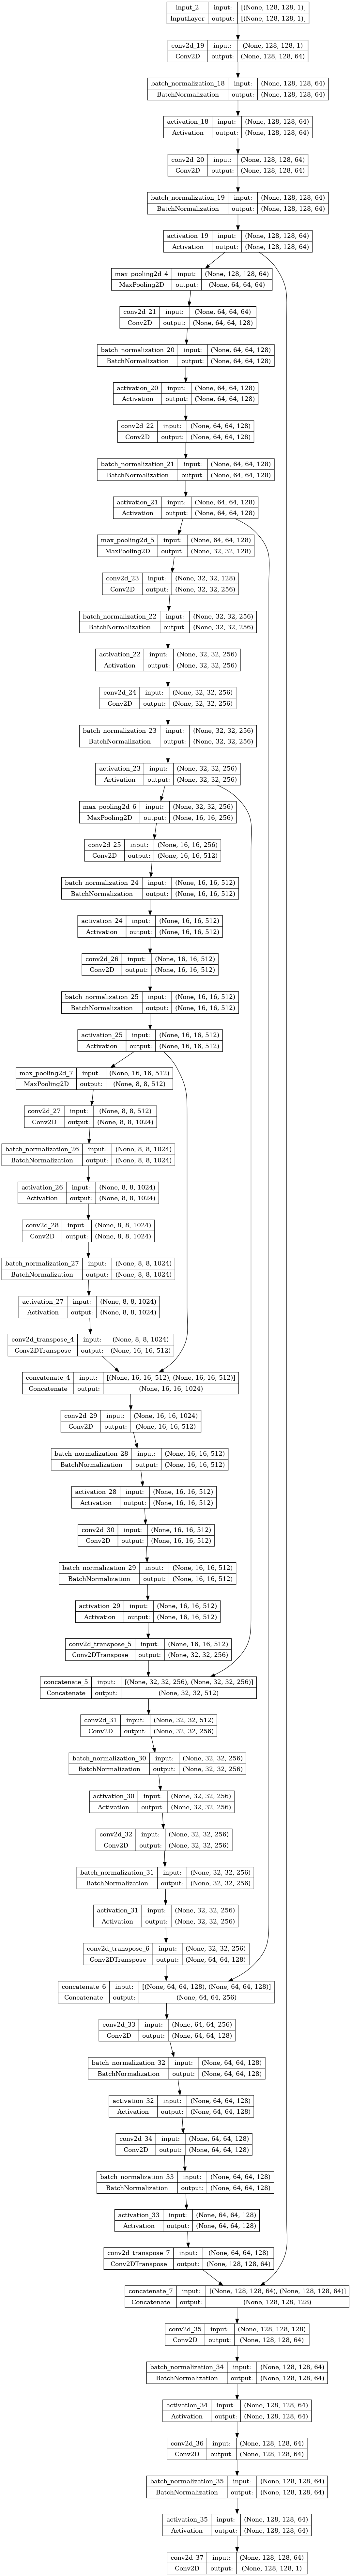

In [29]:
keras.utils.plot_model(model, './model_plot.png', show_shapes = True)

In [30]:
from keras.metrics import MeanIoU

In [31]:
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam(learning_rate = 0.00001),metrics=['acc'])

In [33]:
from keras.callbacks import ModelCheckpoint

In [34]:
checkp = ModelCheckpoint('./unet_model.h5', monitor = 'accuracy', save_best_only = True, verbose = 1)

# Trainning model

In [35]:
history = model.fit(X_train, y_train, epochs = 200, batch_size = 8, validation_data = (X_test, y_test), callbacks = [checkp])

Epoch 1/200
415/415 [==============================] - 57s 84ms/step - loss: 0.0912 - acc: 0.9202 - val_loss: 0.0718 - val_acc: 0.9356
Epoch 2/200
415/415 [==============================] - 33s 79ms/step - loss: 0.0500 - acc: 0.9488 - val_loss: 0.0416 - val_acc: 0.9582
Epoch 3/200
415/415 [==============================] - 31s 76ms/step - loss: 0.0401 - acc: 0.9560 - val_loss: 0.0348 - val_acc: 0.9608
Epoch 4/200
415/415 [==============================] - 31s 76ms/step - loss: 0.0341 - acc: 0.9616 - val_loss: 0.0350 - val_acc: 0.9580
Epoch 5/200
415/415 [==============================] - 32s 78ms/step - loss: 0.0298 - acc: 0.9659 - val_loss: 0.0312 - val_acc: 0.9629
Epoch 6/200
415/415 [==============================] - 33s 79ms/step - loss: 0.0260 - acc: 0.9697 - val_loss: 0.0276 - val_acc: 0.9670
Epoch 7/200
415/415 [==============================] - 32s 78ms/step - loss: 0.0232 - acc: 0.9725 - val_loss: 0.0254 - val_acc: 0.9697
Epoch 8/200
415/415 [==============================] - 

In [36]:
def plotOutput(history, className, epochs):
    k = ''
    if 'accuracy' in history.history :
        k = 'accuracy'    

    if 'acc' in history.history :
        k = 'acc'
    
    acc = history.history[k]
    val_acc = history.history['val_'+k]

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

# Model Metrics

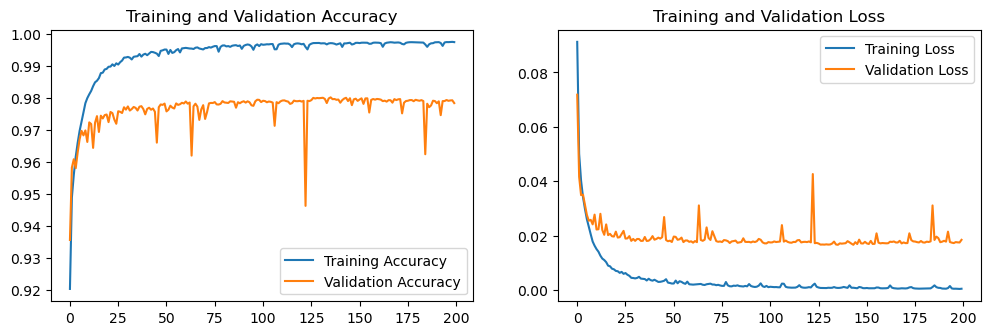

<Figure size 640x480 with 0 Axes>

In [37]:
plotOutput(history, 'Breast cancer', 200)

In [38]:
#6508s
score = model.evaluate(X_test, y_test, verbose = 1) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1]*100)

19/19 [==============================] - 5s 127ms/step - loss: 0.0184 - acc: 0.9784
Test loss: 0.01840493641793728
Test accuracy: 97.83805012702942


In [39]:
model.save("./unet.h5")

In [40]:
def imgpredicting(img):
    x=[]
    x.append(img)
    x=np.array(x)
    output=model.predict(x)
    #print(output)
    output=np.array(output)
    output.shape
    array = np.reshape(output[0], (128, 128))
    print(array.shape)
    return array

1/1 [==============================] - 0s 424ms/step
(128, 128)


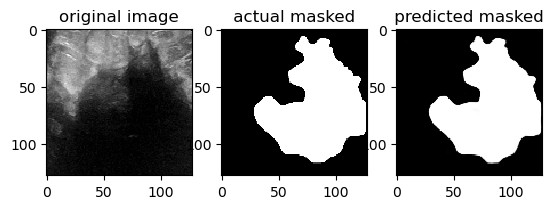

In [41]:
plt.figure
plt.subplot(1,3,1)
plt.imshow(actual[3000],interpolation='nearest',cmap='gray')
plt.title("original image")
plt.subplot(1,3,2)
plt.imshow(mask[3000],interpolation='nearest',cmap='gray')
plt.title(" actual masked ")
plt.subplot(1,3,3)
plt.imshow(imgpredicting(actual[3000]),interpolation='nearest',cmap='gray')
plt.title(" predicted masked ")
plt.show()